ENHANCED RENEWABLE ENERGY SYSTEM OPTIMIZATION

1. Running Primary Optimization...
Starting Particle Swarm Optimization...
Particles: 25, Iterations: 60
------------------------------------------------------------
Iteration  10: Best = $   24,498.91, Avg = $   28,355.16, Config = [53, 0, 0]
Iteration  20: Best = $   24,304.16, Avg = $   25,389.48, Config = [53, 0, 0]
Iteration  30: Best = $   24,272.36, Avg = $   24,908.85, Config = [53, 0, 0]
Iteration  40: Best = $   24,266.69, Avg = $   24,562.49, Config = [53, 0, 0]
Iteration  50: Best = $   24,266.69, Avg = $   24,417.03, Config = [53, 0, 0]
Iteration  60: Best = $   24,266.69, Avg = $   24,370.09, Config = [53, 0, 0]
------------------------------------------------------------
Optimization Complete!

OPTIMAL CONFIGURATION:
  PV Panels     : 53
  Wind Turbines : 0
  Batteries     : 0
  Total Cost    : $24,266.69
  Energy Output : 16.0 MWh/day
  Demand Met    : Yes

2. Generating Convergence Analysis...


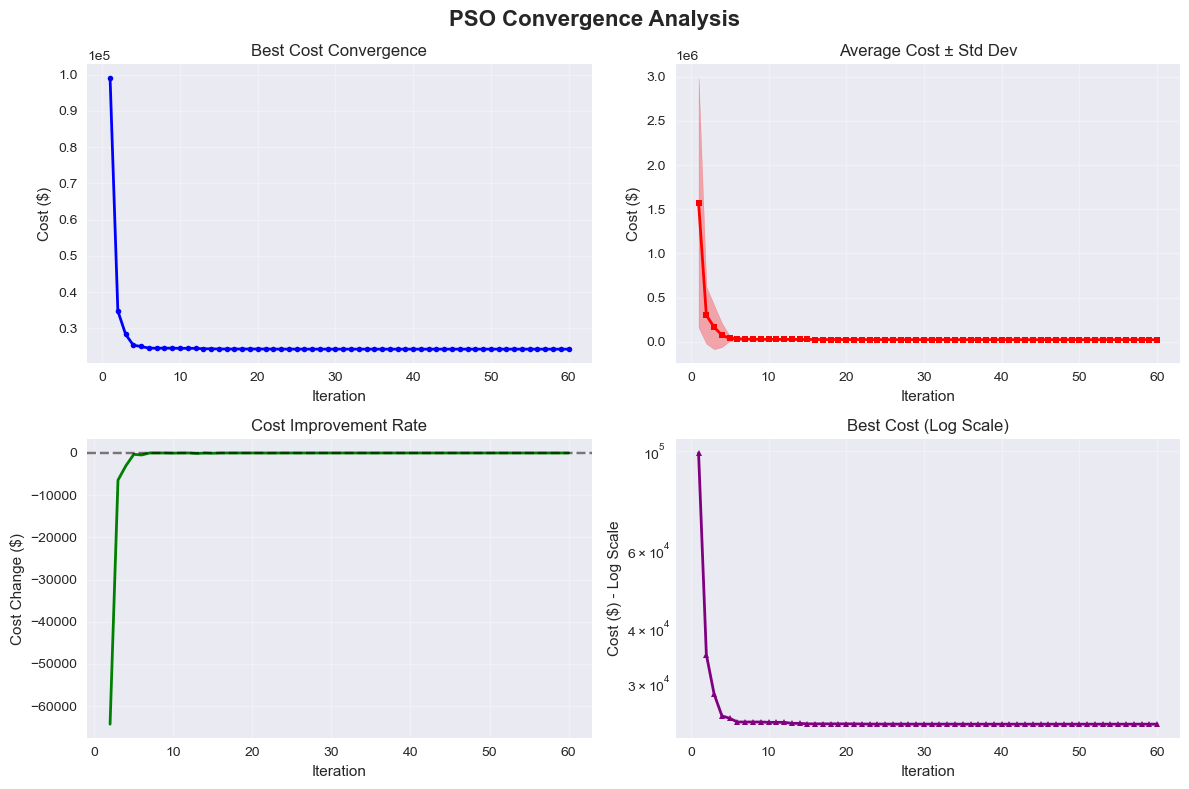


3. Generating Cost Breakdown Analysis...


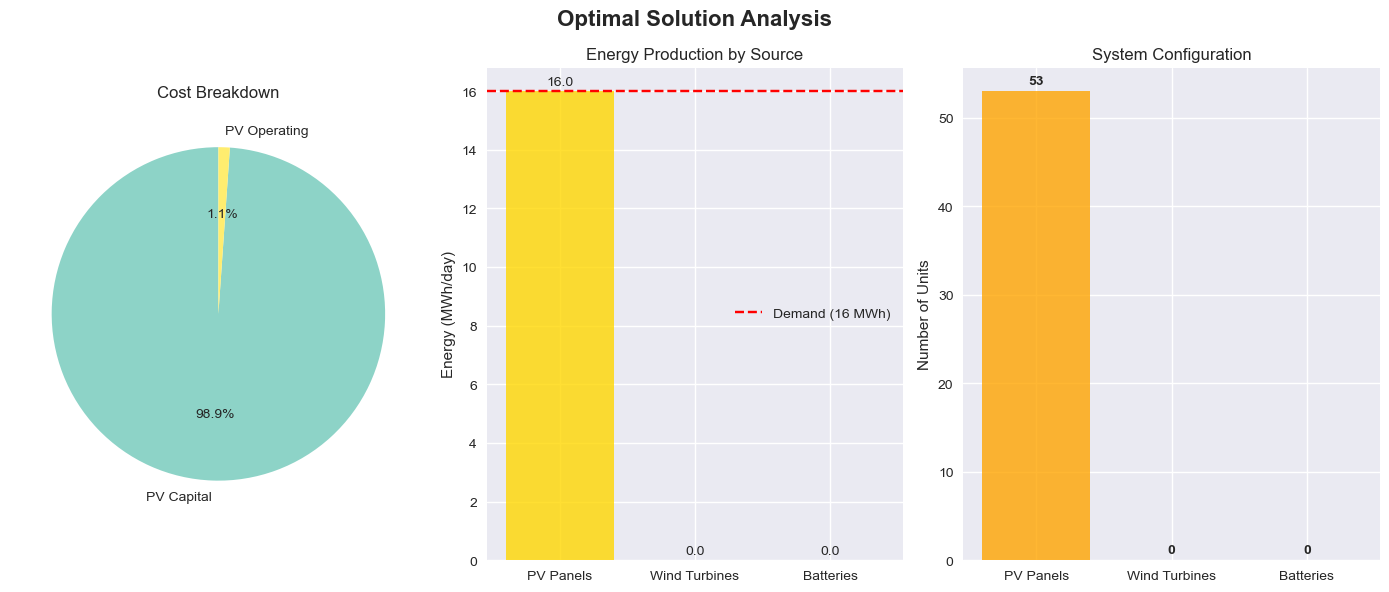


4. Performing Sensitivity Analysis...


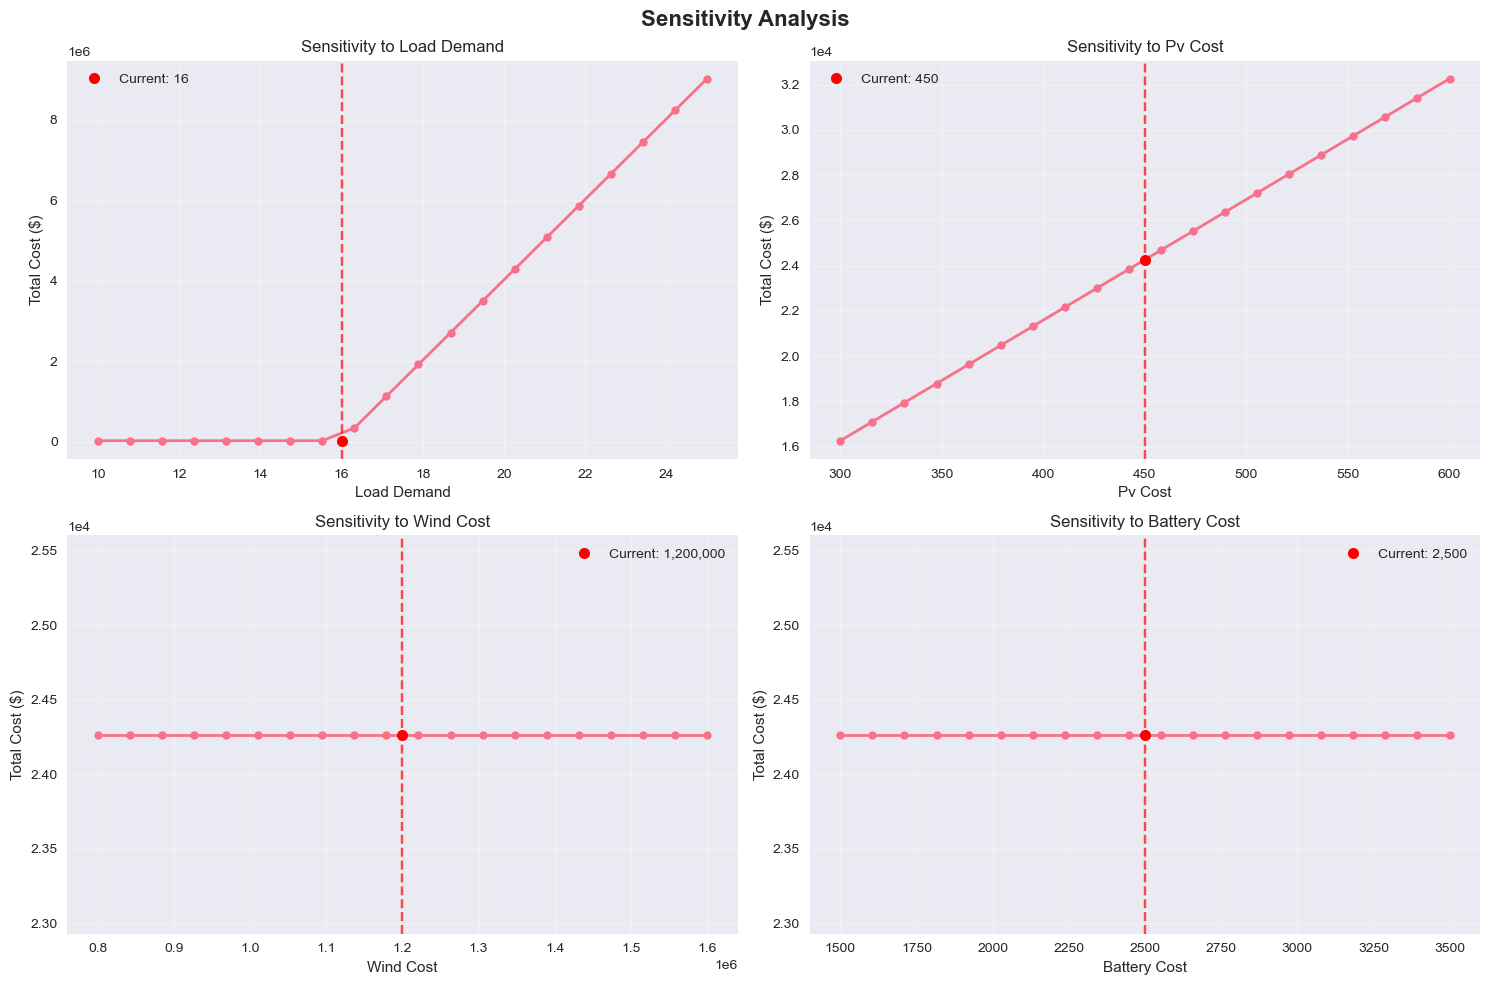


5. Comparing Different Demand Scenarios...
Starting Particle Swarm Optimization...
Particles: 15, Iterations: 30
------------------------------------------------------------
------------------------------------------------------------
Optimization Complete!
Starting Particle Swarm Optimization...
Particles: 15, Iterations: 30
------------------------------------------------------------
------------------------------------------------------------
Optimization Complete!
Starting Particle Swarm Optimization...
Particles: 15, Iterations: 30
------------------------------------------------------------
------------------------------------------------------------
Optimization Complete!
Starting Particle Swarm Optimization...
Particles: 15, Iterations: 30
------------------------------------------------------------
------------------------------------------------------------
Optimization Complete!


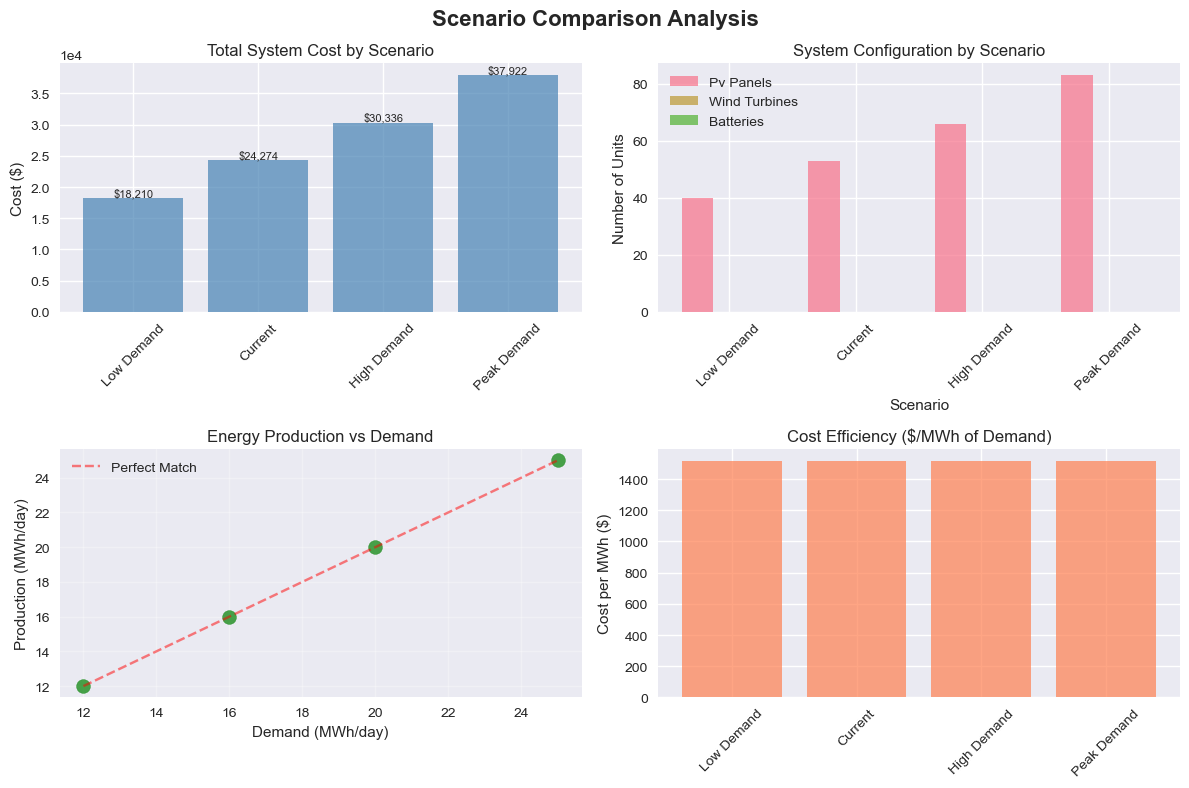


Scenario Comparison Results:
   scenario  demand         cost  pv_panels  wind_turbines  batteries
 Low Demand      12 18210.018091         40              0          0
    Current      16 24274.138944         53              0          0
High Demand      20 30336.351731         66              0          0
Peak Demand      25 37922.231941         83              0          0

ANALYSIS COMPLETE - Check the generated plots for detailed insights!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
import pandas as pd
from typing import Tuple, Dict, List
import time

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class RenewableEnergyOptimizer:
    def __init__(self, load_demand=16, pv_cost=450, wind_cost=1_200_000, battery_cost=2500):
        """
        Enhanced Renewable Energy System Optimizer with visualization capabilities
        
        Parameters:
        - load_demand: Daily energy demand in MWh
        - pv_cost: Cost per PV panel ($)
        - wind_cost: Cost per wind turbine ($)
        - battery_cost: Cost per battery unit ($)
        """
        self.load_demand = load_demand
        self.pv_cost = pv_cost
        self.wind_cost = wind_cost
        self.battery_cost = battery_cost
        
        # Energy production rates (MWh/day)
        self.pv_energy_rate = 0.3
        self.wind_energy_rate = 5.0
        self.battery_energy_rate = 0.1
        
        # Operating costs ($/year)
        self.pv_op_cost = 5
        self.wind_op_cost = 200
        self.battery_op_cost = 20
        
        # Optimization history
        self.convergence_history = []
        self.particle_history = []
        
    def energy_cost(self, variables: np.ndarray, return_details=False) -> float:
        """
        Calculate total energy system cost with detailed breakdown
        """
        num_pv, num_wind, num_battery = variables
        
        # Capital costs
        cost_pv = self.pv_cost * num_pv
        cost_wind = self.wind_cost * num_wind
        cost_battery = self.battery_cost * num_battery
        
        # Operating costs (annual)
        op_pv = self.pv_op_cost * num_pv
        op_wind = self.wind_op_cost * num_wind
        op_battery = self.battery_op_cost * num_battery
        
        # Energy contribution (MWh/day)
        energy_pv = num_pv * self.pv_energy_rate
        energy_wind = num_wind * self.wind_energy_rate
        energy_battery = num_battery * self.battery_energy_rate
        total_energy = energy_pv + energy_wind + energy_battery
        
        # Penalty for not meeting demand
        penalty = 0
        if total_energy < self.load_demand:
            penalty = 1e6 * (self.load_demand - total_energy)
        
        total_cost = cost_pv + cost_wind + cost_battery + op_pv + op_wind + op_battery + penalty
        
        if return_details:
            return {
                'total_cost': total_cost,
                'capital_costs': {'pv': cost_pv, 'wind': cost_wind, 'battery': cost_battery},
                'operating_costs': {'pv': op_pv, 'wind': op_wind, 'battery': op_battery},
                'energy_production': {'pv': energy_pv, 'wind': energy_wind, 'battery': energy_battery},
                'total_energy': total_energy,
                'penalty': penalty,
                'demand_met': total_energy >= self.load_demand
            }
        
        return total_cost
    
    def pso_optimize(self, num_particles=20, max_iter=50, bounds=None, verbose=True):
        """
        Enhanced Particle Swarm Optimization with tracking
        """
        if bounds is None:
            bounds = [(0, 200), (0, 5), (0, 500)]  # [pv_min_max, wind_min_max, battery_min_max]
        
        dim = 3
        w = 0.7  # inertia weight
        c1, c2 = 1.5, 1.5  # acceleration constants
        
        # Initialize particles
        pos = np.zeros((num_particles, dim))
        vel = np.zeros((num_particles, dim))
        
        for i in range(dim):
            pos[:, i] = np.random.uniform(bounds[i][0], bounds[i][1], num_particles)
            vel[:, i] = np.random.uniform(-1, 1, num_particles)
        
        # Initialize personal and global bests
        pbest = pos.copy()
        pbest_val = np.array([self.energy_cost(x) for x in pos])
        gbest = pbest[np.argmin(pbest_val)].copy()
        gbest_val = np.min(pbest_val)
        
        # Reset tracking arrays
        self.convergence_history = []
        self.particle_history = []
        
        print("Starting Particle Swarm Optimization...")
        print(f"Particles: {num_particles}, Iterations: {max_iter}")
        print("-" * 60)
        
        for iteration in range(max_iter):
            for i in range(num_particles):
                # Update velocity
                r1, r2 = np.random.rand(dim), np.random.rand(dim)
                vel[i] = w * vel[i] + c1 * r1 * (pbest[i] - pos[i]) + c2 * r2 * (gbest - pos[i])
                
                # Update position
                pos[i] += vel[i]
                
                # Apply bounds
                for j in range(dim):
                    pos[i, j] = np.clip(pos[i, j], bounds[j][0], bounds[j][1])
                
                # Evaluate fitness
                fitness = self.energy_cost(pos[i])
                
                # Update personal best
                if fitness < pbest_val[i]:
                    pbest[i] = pos[i].copy()
                    pbest_val[i] = fitness
            
            # Update global best
            min_idx = np.argmin(pbest_val)
            if pbest_val[min_idx] < gbest_val:
                gbest = pbest[min_idx].copy()
                gbest_val = pbest_val[min_idx]
            
            # Store convergence data
            avg_fitness = np.mean(pbest_val)
            self.convergence_history.append({
                'iteration': iteration + 1,
                'best_cost': gbest_val,
                'avg_cost': avg_fitness,
                'std_cost': np.std(pbest_val)
            })
            
            # Store particle positions for animation
            if iteration % 5 == 0:  # Store every 5th iteration to save memory
                self.particle_history.append(pos.copy())
            
            if verbose and (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1:3d}: Best = ${gbest_val:12,.2f}, "
                      f"Avg = ${avg_fitness:12,.2f}, "
                      f"Config = [{int(gbest[0])}, {int(gbest[1])}, {int(gbest[2])}]")
        
        print("-" * 60)
        print("Optimization Complete!")
        
        return gbest, gbest_val
    
    def plot_convergence(self, figsize=(12, 8)):
        """
        Plot convergence history with multiple metrics
        """
        if not self.convergence_history:
            print("No convergence data available. Run optimization first.")
            return
        
        df = pd.DataFrame(self.convergence_history)
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('PSO Convergence Analysis', fontsize=16, fontweight='bold')
        
        # Best cost convergence
        axes[0, 0].plot(df['iteration'], df['best_cost'], 'b-', linewidth=2, marker='o', markersize=4)
        axes[0, 0].set_title('Best Cost Convergence')
        axes[0, 0].set_xlabel('Iteration')
        axes[0, 0].set_ylabel('Cost ($)')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        
        # Average cost convergence
        axes[0, 1].plot(df['iteration'], df['avg_cost'], 'r-', linewidth=2, marker='s', markersize=4)
        axes[0, 1].fill_between(df['iteration'], 
                               df['avg_cost'] - df['std_cost'], 
                               df['avg_cost'] + df['std_cost'], 
                               alpha=0.3, color='red')
        axes[0, 1].set_title('Average Cost ± Std Dev')
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('Cost ($)')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        
        # Cost improvement rate
        cost_improvement = np.diff(df['best_cost'])
        axes[1, 0].plot(df['iteration'][1:], cost_improvement, 'g-', linewidth=2)
        axes[1, 0].set_title('Cost Improvement Rate')
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Cost Change ($)')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Convergence rate (log scale)
        axes[1, 1].semilogy(df['iteration'], df['best_cost'], 'purple', linewidth=2, marker='^', markersize=4)
        axes[1, 1].set_title('Best Cost (Log Scale)')
        axes[1, 1].set_xlabel('Iteration')
        axes[1, 1].set_ylabel('Cost ($) - Log Scale')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_cost_breakdown(self, solution, figsize=(14, 6)):
        """
        Visualize cost breakdown of the optimal solution
        """
        details = self.energy_cost(solution, return_details=True)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle('Optimal Solution Analysis', fontsize=16, fontweight='bold')
        
        # Cost breakdown pie chart
        capital_costs = list(details['capital_costs'].values())
        operating_costs = list(details['operating_costs'].values())
        
        all_costs = capital_costs + operating_costs
        labels = ['PV Capital', 'Wind Capital', 'Battery Capital', 
                 'PV Operating', 'Wind Operating', 'Battery Operating']
        
        # Filter out zero costs
        non_zero_costs = [(cost, label) for cost, label in zip(all_costs, labels) if cost > 0]
        if non_zero_costs:
            costs, labels = zip(*non_zero_costs)
            colors = plt.cm.Set3(np.linspace(0, 1, len(costs)))
            
            wedges, texts, autotexts = ax1.pie(costs, labels=labels, autopct='%1.1f%%', 
                                              colors=colors, startangle=90)
            ax1.set_title('Cost Breakdown')
        
        # Energy production bar chart
        energy_sources = ['PV Panels', 'Wind Turbines', 'Batteries']
        energy_values = list(details['energy_production'].values())
        colors = ['gold', 'skyblue', 'lightgreen']
        
        bars = ax2.bar(energy_sources, energy_values, color=colors, alpha=0.8)
        ax2.set_title('Energy Production by Source')
        ax2.set_ylabel('Energy (MWh/day)')
        ax2.axhline(y=self.load_demand, color='red', linestyle='--', 
                   label=f'Demand ({self.load_demand} MWh)')
        ax2.legend()
        
        # Add value labels on bars
        for bar, value in zip(bars, energy_values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{value:.1f}', ha='center', va='bottom')
        
        # System configuration
        config = [int(solution[0]), int(solution[1]), int(solution[2])]
        components = ['PV Panels', 'Wind Turbines', 'Batteries']
        colors = ['orange', 'cyan', 'lime']
        
        bars = ax3.bar(components, config, color=colors, alpha=0.8)
        ax3.set_title('System Configuration')
        ax3.set_ylabel('Number of Units')
        
        # Add value labels on bars
        for bar, value in zip(bars, config):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{value}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return details
    
    def sensitivity_analysis(self, solution, parameter_ranges=None, figsize=(15, 10)):
        """
        Perform sensitivity analysis on key parameters
        """
        if parameter_ranges is None:
            parameter_ranges = {
                'load_demand': np.linspace(10, 25, 20),
                'pv_cost': np.linspace(300, 600, 20),
                'wind_cost': np.linspace(800_000, 1_600_000, 20),
                'battery_cost': np.linspace(1500, 3500, 20)
            }
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Sensitivity Analysis', fontsize=16, fontweight='bold')
        
        original_values = {
            'load_demand': self.load_demand,
            'pv_cost': self.pv_cost,
            'wind_cost': self.wind_cost,
            'battery_cost': self.battery_cost
        }
        
        for idx, (param, values) in enumerate(parameter_ranges.items()):
            ax = axes[idx // 2, idx % 2]
            costs = []
            
            for value in values:
                # Temporarily change parameter
                setattr(self, param, value)
                cost = self.energy_cost(solution)
                costs.append(cost)
            
            # Restore original value
            setattr(self, param, original_values[param])
            
            ax.plot(values, costs, 'o-', linewidth=2, markersize=6)
            ax.set_title(f'Sensitivity to {param.replace("_", " ").title()}')
            ax.set_xlabel(param.replace("_", " ").title())
            ax.set_ylabel('Total Cost ($)')
            ax.grid(True, alpha=0.3)
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
            
            # Mark current value
            current_val = original_values[param]
            current_cost = self.energy_cost(solution)
            ax.axvline(x=current_val, color='red', linestyle='--', alpha=0.7)
            ax.plot(current_val, current_cost, 'ro', markersize=8, 
                   label=f'Current: {current_val:,.0f}')
            ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def compare_scenarios(self, scenarios, figsize=(12, 8)):
        """
        Compare different demand scenarios
        """
        results = []
        
        for scenario_name, demand in scenarios.items():
            original_demand = self.load_demand
            self.load_demand = demand
            
            # Quick optimization for each scenario
            solution, cost = self.pso_optimize(num_particles=15, max_iter=30, verbose=False)
            details = self.energy_cost(solution, return_details=True)
            
            results.append({
                'scenario': scenario_name,
                'demand': demand,
                'solution': solution,
                'cost': cost,
                'pv_panels': int(solution[0]),
                'wind_turbines': int(solution[1]),
                'batteries': int(solution[2]),
                'total_energy': details['total_energy']
            })
            
            self.load_demand = original_demand  # Restore
        
        df = pd.DataFrame(results)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Scenario Comparison Analysis', fontsize=16, fontweight='bold')
        
        # Cost comparison
        bars = ax1.bar(df['scenario'], df['cost'], color='steelblue', alpha=0.7)
        ax1.set_title('Total System Cost by Scenario')
        ax1.set_ylabel('Cost ($)')
        ax1.tick_params(axis='x', rotation=45)
        ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        
        # Add value labels
        for bar, cost in zip(bars, df['cost']):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'${cost:,.0f}', ha='center', va='bottom', fontsize=8)
        
        # Component comparison
        components = ['pv_panels', 'wind_turbines', 'batteries']
        x = np.arange(len(df))
        width = 0.25
        
        for i, component in enumerate(components):
            ax2.bar(x + i*width, df[component], width, 
                   label=component.replace('_', ' ').title(),
                   alpha=0.7)
        
        ax2.set_title('System Configuration by Scenario')
        ax2.set_xlabel('Scenario')
        ax2.set_ylabel('Number of Units')
        ax2.set_xticks(x + width)
        ax2.set_xticklabels(df['scenario'], rotation=45)
        ax2.legend()
        
        # Demand vs Energy Production
        ax3.scatter(df['demand'], df['total_energy'], s=100, alpha=0.7, color='green')
        ax3.plot([df['demand'].min(), df['demand'].max()], 
                [df['demand'].min(), df['demand'].max()], 
                'r--', alpha=0.5, label='Perfect Match')
        ax3.set_title('Energy Production vs Demand')
        ax3.set_xlabel('Demand (MWh/day)')
        ax3.set_ylabel('Production (MWh/day)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Cost efficiency (cost per MWh)
        efficiency = df['cost'] / df['demand']
        ax4.bar(df['scenario'], efficiency, color='coral', alpha=0.7)
        ax4.set_title('Cost Efficiency ($/MWh of Demand)')
        ax4.set_ylabel('Cost per MWh ($)')
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return df

def main():
    """
    Main function demonstrating the enhanced optimization tool
    """
    print("=" * 70)
    print("ENHANCED RENEWABLE ENERGY SYSTEM OPTIMIZATION")
    print("=" * 70)
    
    # Initialize optimizer
    optimizer = RenewableEnergyOptimizer(
        load_demand=16,
        pv_cost=450,
        wind_cost=1_200_000,
        battery_cost=2500
    )
    
    # Run optimization
    print("\n1. Running Primary Optimization...")
    best_solution, best_cost = optimizer.pso_optimize(num_particles=25, max_iter=60)
    
    # Display results
    details = optimizer.energy_cost(best_solution, return_details=True)
    print(f"\nOPTIMAL CONFIGURATION:")
    print(f"  PV Panels     : {int(best_solution[0]):,}")
    print(f"  Wind Turbines : {int(best_solution[1]):,}")
    print(f"  Batteries     : {int(best_solution[2]):,}")
    print(f"  Total Cost    : ${best_cost:,.2f}")
    print(f"  Energy Output : {details['total_energy']:.1f} MWh/day")
    print(f"  Demand Met    : {'Yes' if details['demand_met'] else 'No'}")
    
    # Visualizations
    print("\n2. Generating Convergence Analysis...")
    optimizer.plot_convergence()
    
    print("\n3. Generating Cost Breakdown Analysis...")
    optimizer.plot_cost_breakdown(best_solution)
    
    print("\n4. Performing Sensitivity Analysis...")
    optimizer.sensitivity_analysis(best_solution)
    
    print("\n5. Comparing Different Demand Scenarios...")
    scenarios = {
        'Low Demand': 12,
        'Current': 16,
        'High Demand': 20,
        'Peak Demand': 25
    }
    scenario_results = optimizer.compare_scenarios(scenarios)
    
    print("\nScenario Comparison Results:")
    print(scenario_results[['scenario', 'demand', 'cost', 'pv_panels', 'wind_turbines', 'batteries']].to_string(index=False))
    
    print("\n" + "=" * 70)
    print("ANALYSIS COMPLETE - Check the generated plots for detailed insights!")
    print("=" * 70)

if __name__ == "__main__":
    main()